## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80, frameon=False)

### Load data and preprocess

In [2]:
%time s1 = sc.read_h5ad('../data/colon_10x.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1.69 s, sys: 278 ms, total: 1.96 s
Wall time: 2.01 s


In [3]:
s1

AnnData object with n_obs × n_vars = 5000 × 27998 
    obs: 'ken_filter'

In [4]:
# checkpoint raw data for future filtering
s1.raw = s1

In [9]:
s1.var_names_make_unique()

In [10]:
s1.var_names[s1.var_names.str.contains('MT-|mt-')] # check gene label format

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object')

In [7]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 1.59 s, sys: 378 ms, total: 1.97 s
Wall time: 1.97 s


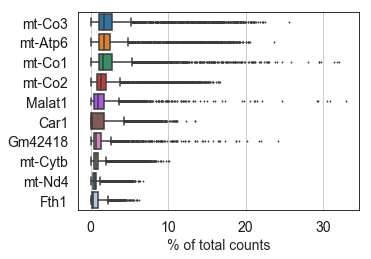

In [11]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

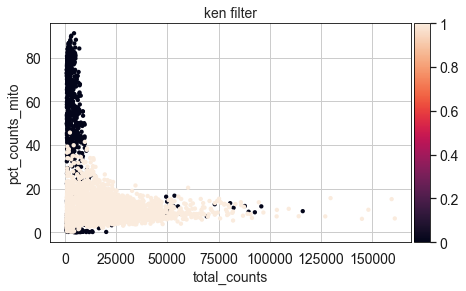

In [12]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Find inflection point

Inflection point at index
4999    2386
4000    1838
3000    1247
1500     463
1000    4259
500       99
0       4999
Name: total_counts, dtype: int64 for [0, 20, 40, 70, 80, 90, 100] percentiles of greatest secant distances


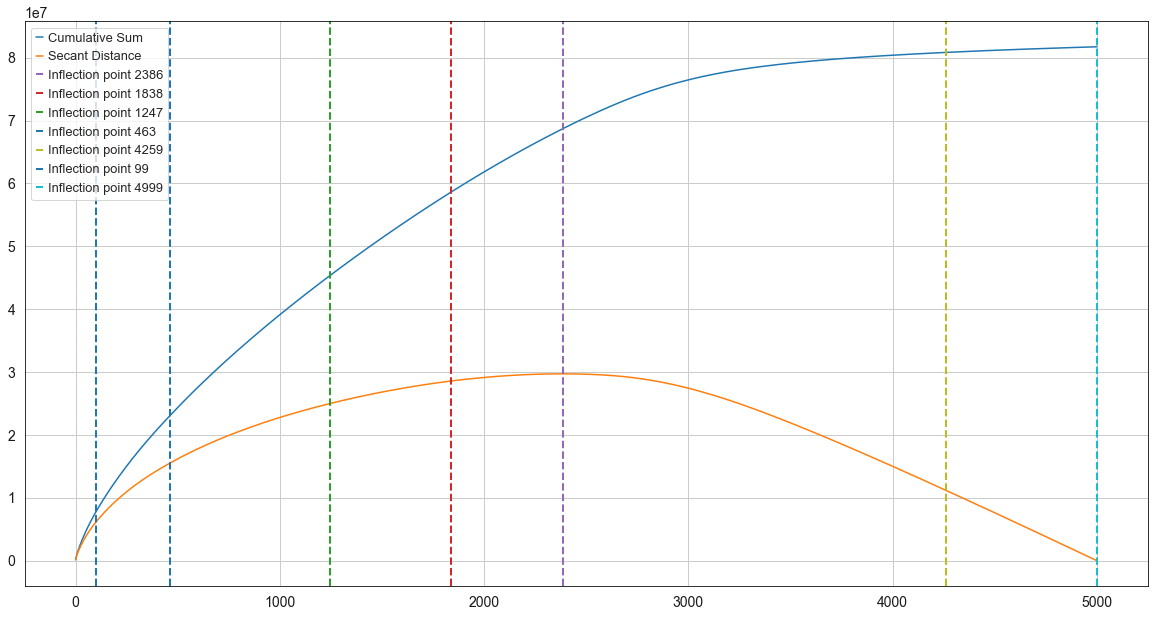

In [14]:
find_inflection(s1, inflection_percentiles = [0,20,40,70,80,90,100])

In [15]:
s1.obs['total_counts'][4259] # see the total counts for the cutoff point

1542.0

In [16]:
# create new "observation" as empty droplet label
s1.obs['bagging_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][4259], 1, 0) # 1 is "empty", 0 is __initially__ "not empty"

In [17]:
s1.obs['bagging_empty'].value_counts()

0    4259
1     741
Name: bagging_empty, dtype: int64

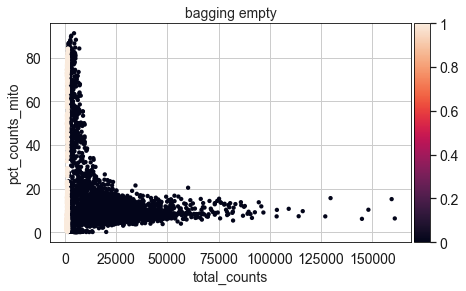

In [18]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_empty', size=75)

### Normalize and perform linear dimensionality reduction with PCA

In [19]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 945 ms, sys: 116 ms, total: 1.06 s
Wall time: 1.06 s


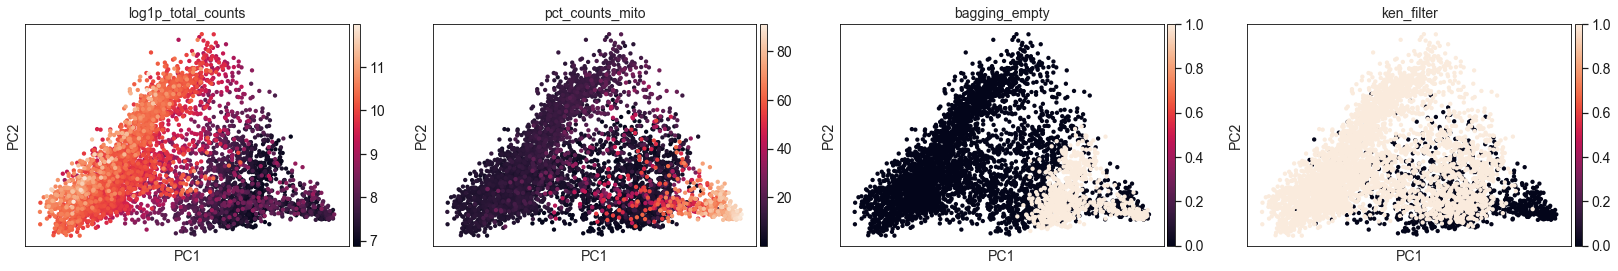

CPU times: user 27.3 s, sys: 2.24 s, total: 29.6 s
Wall time: 4.76 s


In [20]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','bagging_empty','ken_filter'], ncols=4, size=75)

---
### PU Bagging

In [21]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['bagging_empty'].copy(deep=True) # training labels are from .obs df

In [22]:
%%time

bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

CPU times: user 3.33 s, sys: 195 ms, total: 3.52 s
Wall time: 17.4 s


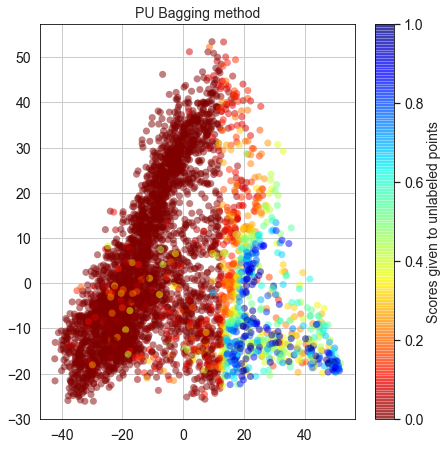

In [23]:
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

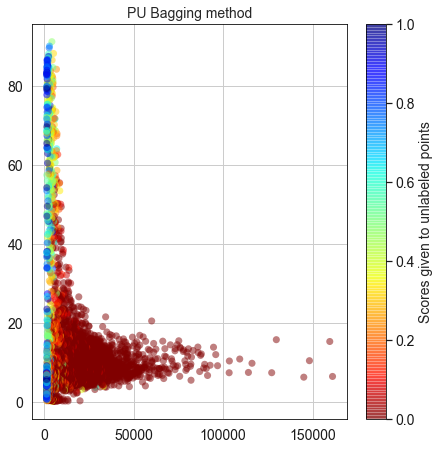

In [24]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

In [25]:
s1.obs['bagging_result'] = np.where(results_bagging_empty!=0, 1, 0)

In [26]:
s1.obs['ken_filter'].value_counts()

1    3954
0    1046
Name: ken_filter, dtype: int64

In [27]:
s1.obs['bagging_result'].value_counts()

0    2817
1    2183
Name: bagging_result, dtype: int64

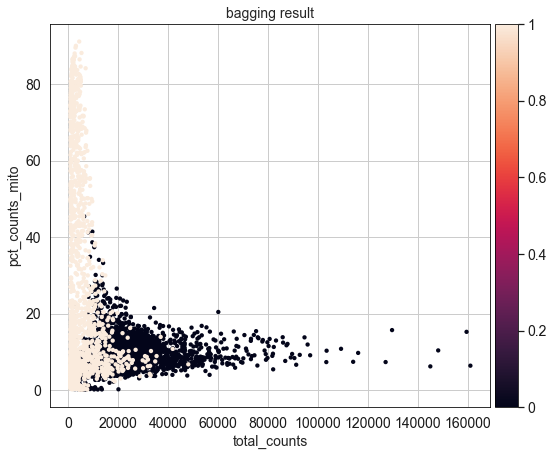

In [28]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_result', size=75)

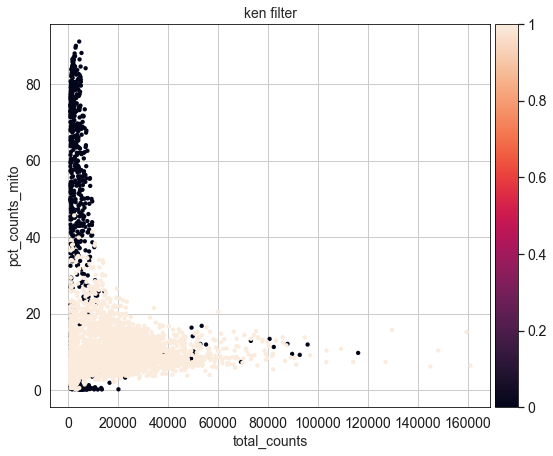

In [29]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [30]:
s1_notempty = s1[s1.obs['bagging_result']==0,:].copy() # move forward with non-empty droplets

In [31]:
s1_notempty.X = s1_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [32]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 553 ms, sys: 23.7 ms, total: 576 ms
Wall time: 576 ms


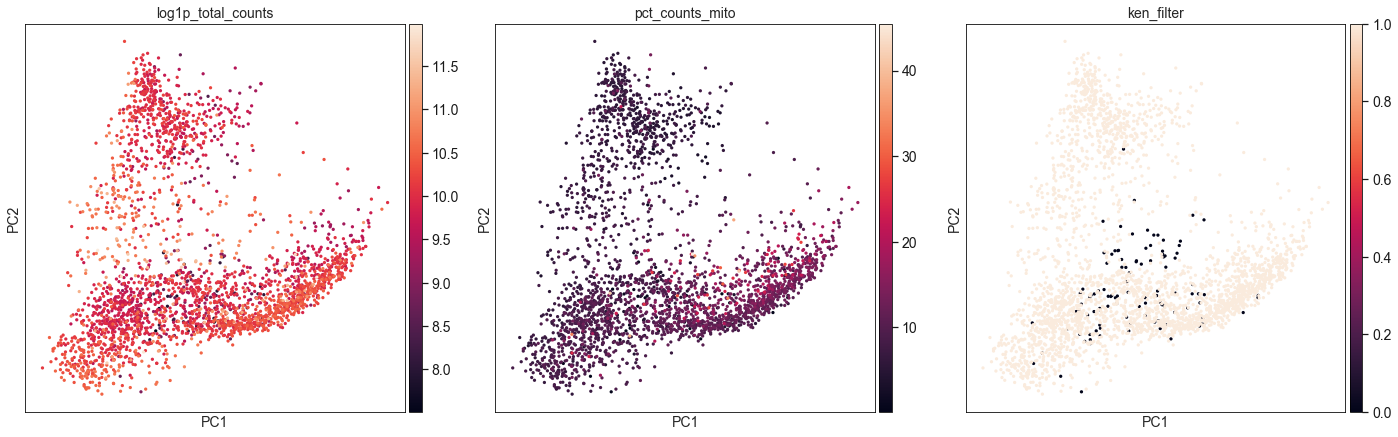

CPU times: user 19 s, sys: 2.29 s, total: 21.3 s
Wall time: 3.05 s


In [33]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

### Clustering

In [34]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_notempty, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 3.58 s, sys: 155 ms, total: 3.73 s
Wall time: 3.09 s


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


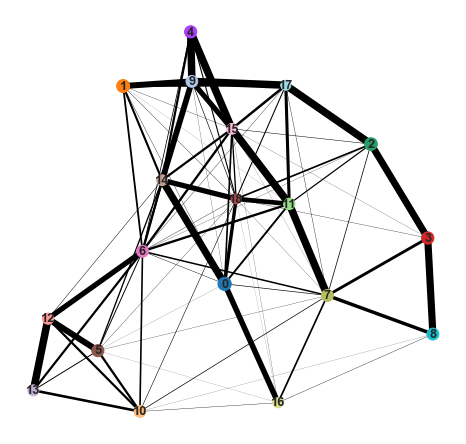

In [35]:
sc.tl.paga(s1_notempty) #perform PAGA
sc.pl.paga(s1_notempty, frameon=False)

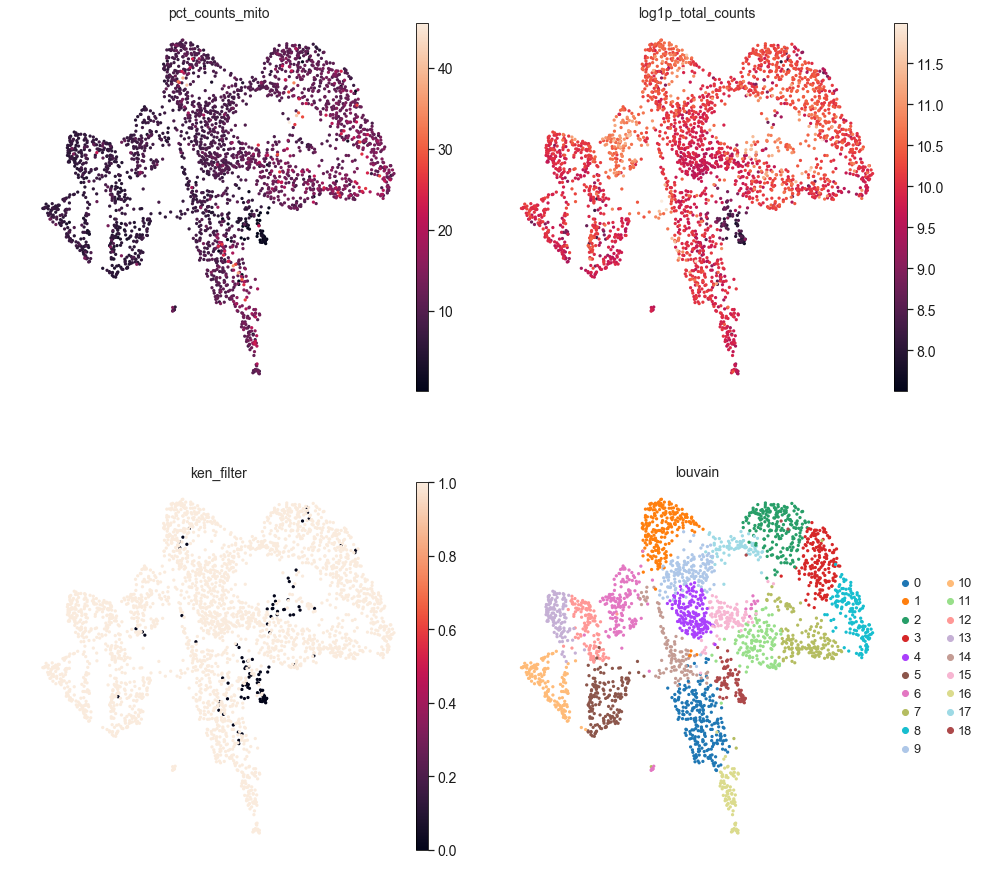

In [36]:
sc.tl.umap(s1_notempty, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_notempty))
sc.pl.umap(s1_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter','louvain'], frameon=False, ncols=2)

---
## Ken Filtering

In [37]:
s1_gold = s1[s1.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets

In [38]:
s1_gold.X = s1_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [39]:
%%time
sc.pp.normalize_total(s1_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_gold) # log1p transformation
sc.pp.scale(s1_gold, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 743 ms, sys: 22.9 ms, total: 766 ms
Wall time: 767 ms


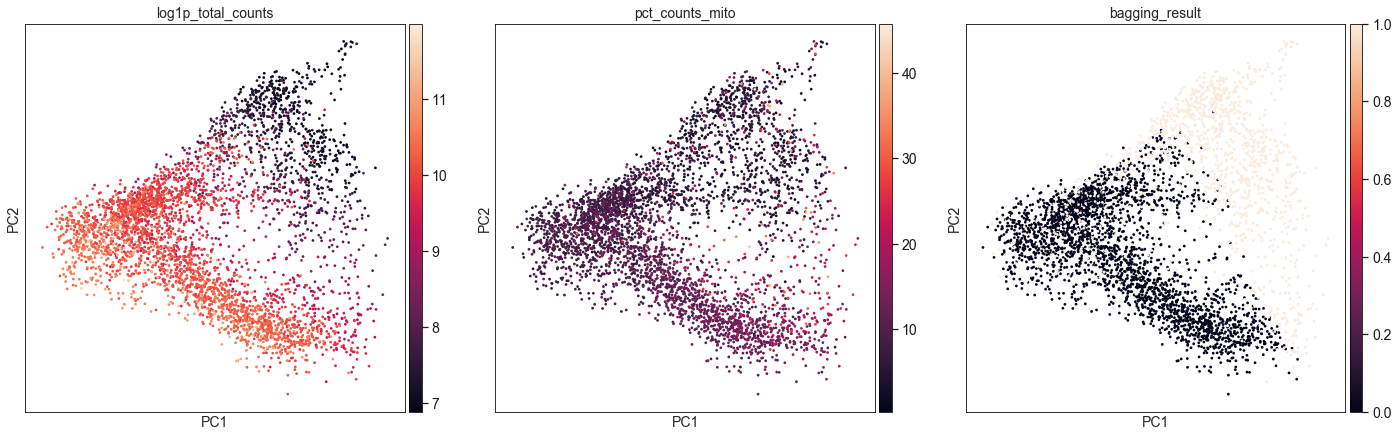

CPU times: user 23.2 s, sys: 2.26 s, total: 25.4 s
Wall time: 3.86 s


In [40]:
%%time
sc.tl.pca(s1_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_gold, color=['log1p_total_counts','pct_counts_mito','bagging_result'], ncols=3)

### Clustering

In [41]:
%%time
sc.pp.neighbors(s1_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_gold, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

CPU times: user 1.44 s, sys: 124 ms, total: 1.56 s
Wall time: 819 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


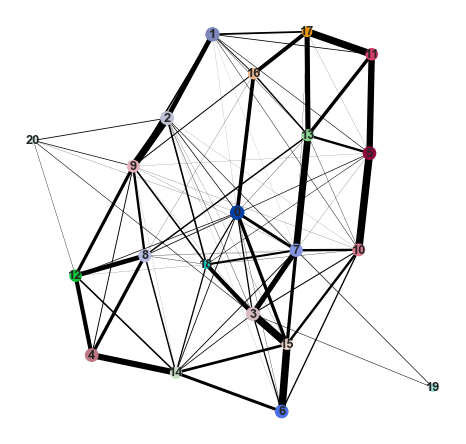

In [42]:
sc.tl.paga(s1_gold) #perform PAGA
sc.pl.paga(s1_gold, frameon=False)

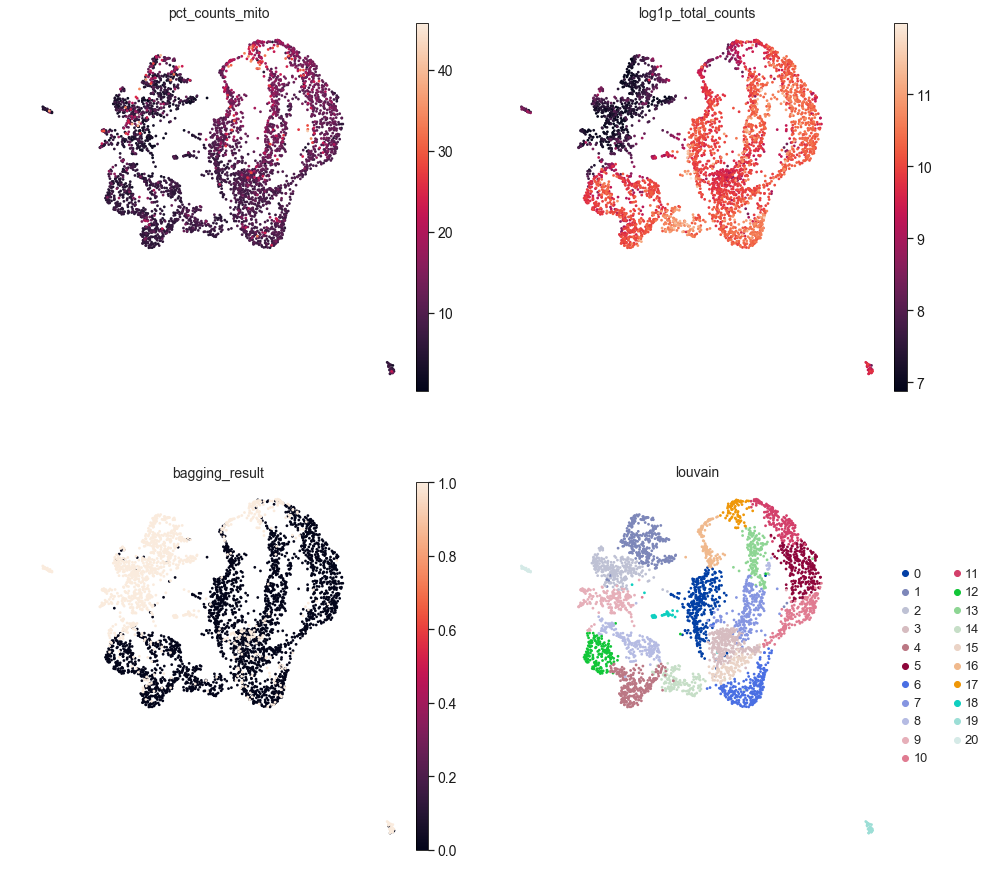

In [43]:
sc.tl.umap(s1_gold, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_gold))
sc.pl.umap(s1_gold, color=['pct_counts_mito','log1p_total_counts','bagging_result','louvain'], frameon=False, ncols=2)